# 1. MAE Model

In [1]:
# Step 1: Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from visionts import VisionTS
from visionts.models_mae import MaskedAutoencoderViT
from torchvision.transforms import ToTensor
from PIL import Image
import os
from timm.models.vision_transformer import PatchEmbed, Block
from sklearn.metrics import mean_squared_error, mean_absolute_error


d:\OneDrive - Dialog Axiata PLC\STUDIES\MSC\Sem 3\PG Dip Project CS5999\VisionTS-main\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# STEP 0: Configurable forecast length
PRED_LEN = 100  # 👈 CHANGE THIS ONLY


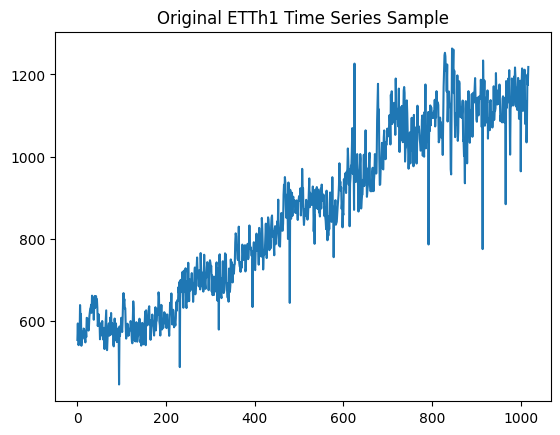

In [4]:
# Step 2: Load a short ETTh1 sequence from CSV

# df = pd.read_csv('./long_term_tsf/dataset/ETT-small/ETTh1.csv')
df = pd.read_csv('./long_term_tsf/dataset/ETT-small/AN0018.csv')

CONTEXT_LEN = len(df) - PRED_LEN
# data = df[['OT']].values.squeeze()[:CONTEXT_LEN + PRED_LEN]
data = df[['dl_traffic_volume_gb']].values.squeeze()[:CONTEXT_LEN + PRED_LEN]
plt.plot(data)
plt.title("Original ETTh1 Time Series Sample")
plt.show()

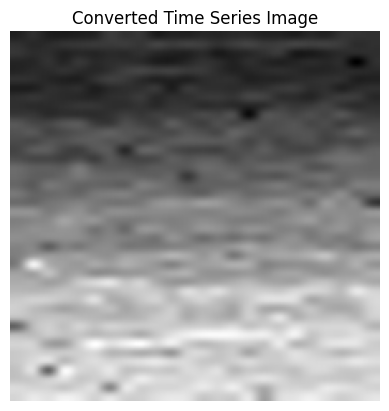

In [5]:
# Step 3: Convert time series to image
def series_to_image(series, context_len, pred_len, periodicity=24):
    total_len = context_len + pred_len
    # truncate to make divisible by periodicity
    usable_len = total_len - (total_len % periodicity)
    matrix = series[:usable_len].reshape(-1, periodicity)
    matrix = (matrix - matrix.min()) / (matrix.max() - matrix.min())
    image = (matrix * 255).astype(np.uint8)
    img = Image.fromarray(image).convert("L").resize((224, 224))
    return img.convert("RGB"), usable_len

img, usable_len = series_to_image(data, CONTEXT_LEN, PRED_LEN)
plt.imshow(img)
plt.title("Converted Time Series Image")
plt.axis('off')
plt.show()

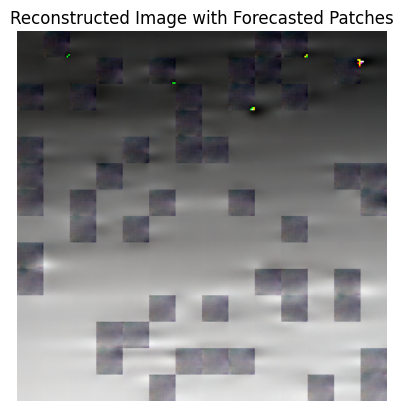

In [6]:
# Step 4: Run MAE reconstruction (simulate zero-shot forecast)
model = MaskedAutoencoderViT(
    img_size=224, patch_size=16, in_chans=3,
    embed_dim=768, depth=12, num_heads=12,
    decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16
)

ckpt_path = './ckpt/mae_visualize_vit_base.pth'
ckpt = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(ckpt['model'], strict=False)
model.eval()

x = ToTensor()(img).unsqueeze(0)
with torch.no_grad():
    latent, mask, ids_restore = model.forward_encoder(x, mask_ratio=0.75)
    pred = model.forward_decoder(latent, ids_restore)
    output = model.unpatchify(pred).squeeze().permute(1, 2, 0).numpy()

output = (output * 255).astype(np.uint8)
reconstructed_img = Image.fromarray(output)
plt.imshow(reconstructed_img)
plt.title("Reconstructed Image with Forecasted Patches")
plt.axis('off')
plt.show()

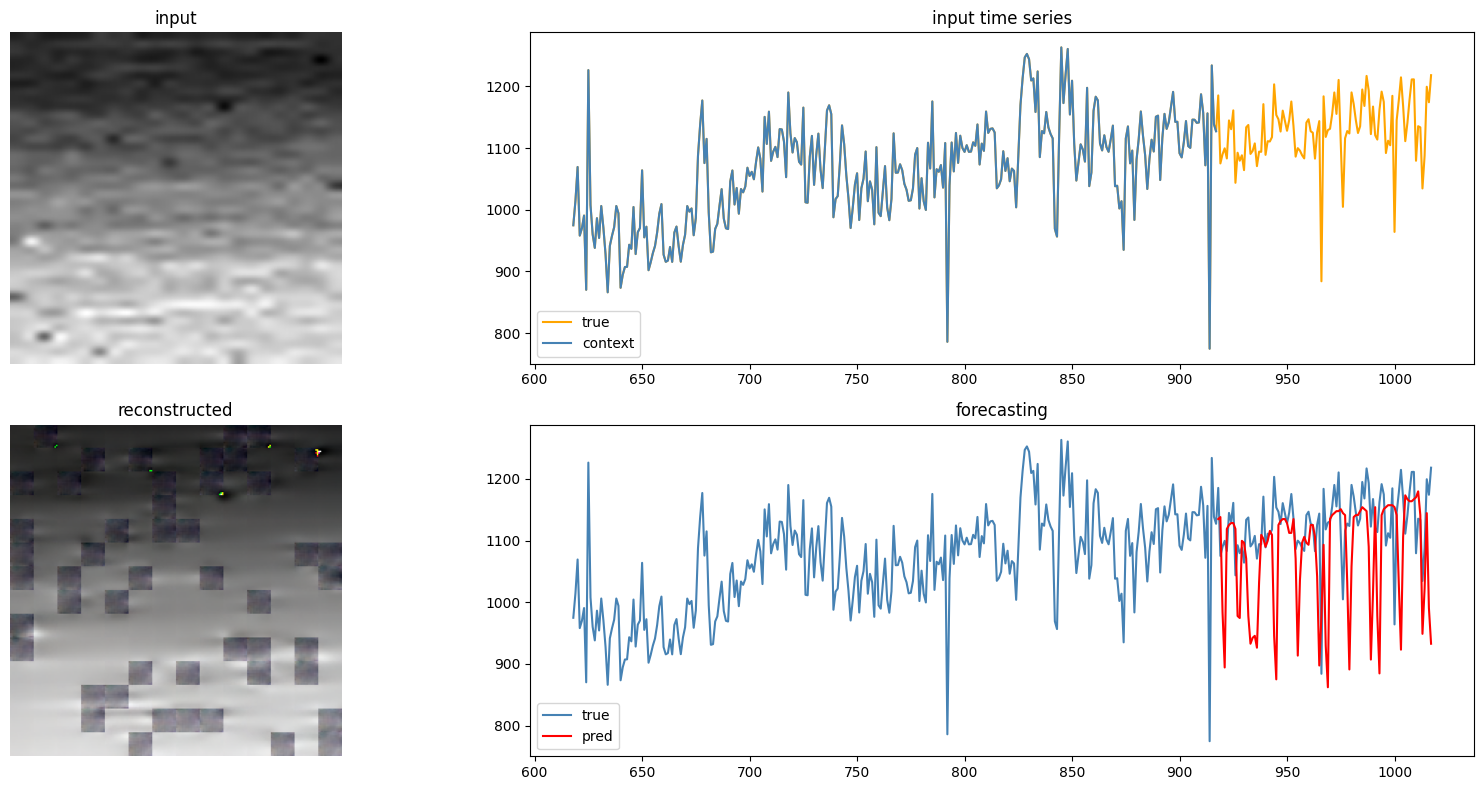

📊 Forecast Evaluation Metrics:
  MSE  = 12185.5486
  MAE  = 78.3696
  RMSE = 110.3882
✅ Success Rate (±10% tolerance): 74.00%


In [7]:
PLOT_CONTEXT_LEN = 300  # 👈 Only change this to zoom in or out

# Convert reconstructed image back to time series
periodicity = 24
matrix_h = (CONTEXT_LEN + PRED_LEN) // periodicity
recon_gray = reconstructed_img.convert("L").resize((periodicity, matrix_h), Image.BILINEAR)
recon_array = np.array(recon_gray).astype(np.float32) / 255.0
reconstructed_series = recon_array.flatten()
forecast_series = reconstructed_series[-PRED_LEN:]

# Denormalize forecast
data_min = data.min()
data_max = data.max()
forecast_denorm = forecast_series * (data_max - data_min) + data_min
full_series = data[:CONTEXT_LEN + PRED_LEN]

# Build predicted sequence
pred_series = np.concatenate([full_series[:CONTEXT_LEN], forecast_denorm])

# --- Plot combined layout like VISIONTS paper ---
fig, axs = plt.subplots(2, 2, figsize=(18, 8))

axs[0, 0].imshow(img)
axs[0, 0].set_title("input")
axs[0, 0].axis("off")

axs[1, 0].imshow(reconstructed_img)
axs[1, 0].set_title("reconstructed")
axs[1, 0].axis("off")

# Plot a zoomed-in portion of the context
axs[0, 1].plot(
    np.arange(CONTEXT_LEN - PLOT_CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    full_series[CONTEXT_LEN - PLOT_CONTEXT_LEN: CONTEXT_LEN + PRED_LEN],
    label="true", color="orange"
)
axs[0, 1].plot(
    np.arange(CONTEXT_LEN - PLOT_CONTEXT_LEN, CONTEXT_LEN),
    full_series[CONTEXT_LEN - PLOT_CONTEXT_LEN: CONTEXT_LEN],
    label="context", color="steelblue"
)
axs[0, 1].set_title("input time series")
axs[0, 1].legend()

# Forecasting plot
axs[1, 1].plot(
    np.arange(CONTEXT_LEN - PLOT_CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    full_series[CONTEXT_LEN - PLOT_CONTEXT_LEN: CONTEXT_LEN + PRED_LEN],
    label="true", color="steelblue"
)
axs[1, 1].plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    forecast_denorm, label="pred", color="red"
)
axs[1, 1].set_title("forecasting")
axs[1, 1].legend()

plt.tight_layout()
plt.show()


# Get ground truth for forecast window
true_forecast = full_series[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

# --- 1. Error Metrics ---
mse = mean_squared_error(true_forecast, forecast_denorm)
mae = mean_absolute_error(true_forecast, forecast_denorm)
rmse = np.sqrt(mse)

# --- 2. Success Rate ---
# Define success as prediction within ±10% of true value
tolerance = 0.10
success_mask = np.abs(forecast_denorm - true_forecast) <= tolerance * np.abs(true_forecast)
success_rate = success_mask.sum() / len(true_forecast)

# --- Print results ---
print(f"📊 Forecast Evaluation Metrics:")
print(f"  MSE  = {mse:.4f}")
print(f"  MAE  = {mae:.4f}")
print(f"  RMSE = {rmse:.4f}")
print(f"✅ Success Rate (±10% tolerance): {success_rate * 100:.2f}%")


# 2. VisionTS Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..2.1465054].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9068073..2.1465054].


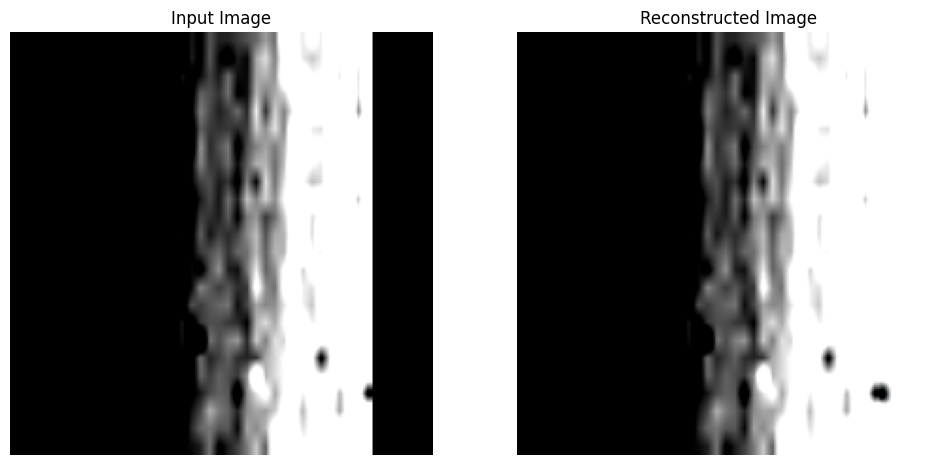

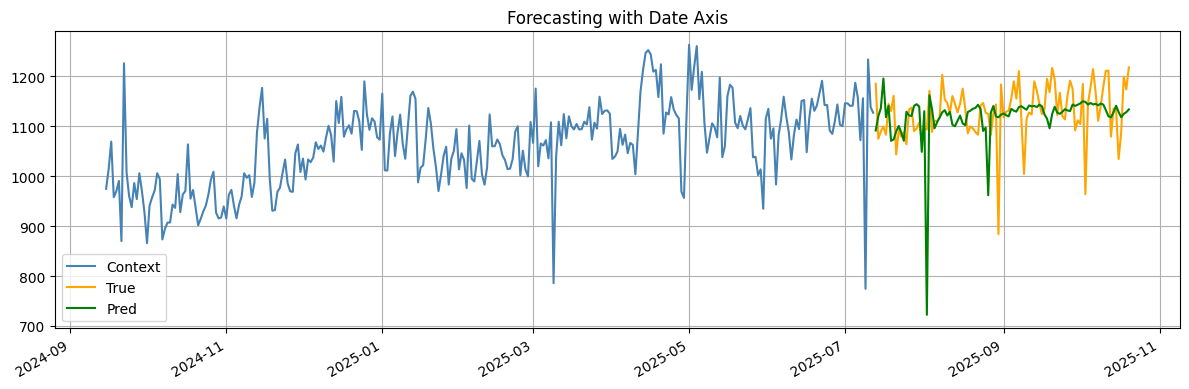

📊 Forecast Evaluation:
  MSE  = 4653.4448
  MAE  = 46.1491
  RMSE = 68.2162
✅ Success Rate (±10% tolerance): 95.00%


In [10]:
# CONFIG
PRED_LEN = 100 #24 * 2
CONTEXT_LEN = len(df) - PRED_LEN
PLOT_CONTEXT_LEN = 300  # 👈 only change this to zoom in/out in plot

DEVICE = 'cpu'  # or 'cuda:0'

# Load series from ETTh1
df = pd.read_csv('./long_term_tsf/dataset/ETT-small/AN0018.csv')
# df = pd.read_csv('./long_term_tsf/dataset/ETT-small/ETTh1.csv')
# df = pd.read_csv('./long_term_tsf/dataset/ETT-small/ETTh2.csv')
# data = df['OT'].values.squeeze()
data = df['dl_traffic_volume_gb'].values.squeeze()
x = data[:CONTEXT_LEN]
y = data[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

# Prepare tensors
import einops
x_tensor = torch.Tensor(einops.rearrange(x, 't -> 1 t 1')).to(DEVICE)
y_tensor = torch.Tensor(einops.rearrange(y, 't -> 1 t 1')).to(DEVICE)

# Load model and set config
from visionts import VisionTS
model = VisionTS('mae_base', './ckpt/').to(DEVICE)
model.update_config(
    context_len=CONTEXT_LEN,
    pred_len=PRED_LEN,
    align_const=1,
    norm_const=1,
    periodicity=24
)
model.eval()

# Run model
with torch.no_grad():
    y_pred, input_img, recon_img = model.forward(x_tensor, export_image=True)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(input_img[0, 0].cpu())
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(recon_img[0, 0].cpu())
plt.title("Reconstructed Image")
plt.axis('off')

# Define plot range
plot_start = CONTEXT_LEN - PLOT_CONTEXT_LEN
plot_end = CONTEXT_LEN + PRED_LEN

# Plot true and predicted values in a focused range
timestamps = pd.to_datetime(df['date'])
time_x = timestamps[:CONTEXT_LEN]
time_y = timestamps[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]
plt.figure(figsize=(12, 4))
plt.plot(time_x[-PLOT_CONTEXT_LEN:], x[-PLOT_CONTEXT_LEN:], label="Context", color='steelblue')
plt.plot(time_y, y, label="True", color='orange')
plt.plot(time_y, y_pred.cpu().squeeze().numpy(), label="Pred", color='green')
plt.gcf().autofmt_xdate()  # rotate x-axis dates
plt.title("Forecasting with Date Axis")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error

# Convert tensors to NumPy
true_vals = y_tensor.cpu().numpy().squeeze()
pred_vals = y_pred.cpu().numpy().squeeze()

# --- Error Metrics ---
mse = mean_squared_error(true_vals, pred_vals)
mae = mean_absolute_error(true_vals, pred_vals)
rmse = np.sqrt(mse)

# --- Success Rate (within ±10% tolerance) ---
tolerance = 0.10
success_mask = np.abs(pred_vals - true_vals) <= tolerance * np.abs(true_vals)
success_rate = success_mask.sum() / len(true_vals)

# --- Print Results ---
print(f"📊 Forecast Evaluation:")
print(f"  MSE  = {mse:.4f}")
print(f"  MAE  = {mae:.4f}")
print(f"  RMSE = {rmse:.4f}")
print(f"✅ Success Rate (±10% tolerance): {success_rate * 100:.2f}%")
